In [1]:
!pip install evaluate

Note: you may need to restart the kernel to use updated packages.


In [1]:
import torch
import torch.nn as nn
from evaluate import load
import operator
from collections import OrderedDict
from PIL import Image
from torchvision import transforms
import os
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

%matplotlib inline

2022-12-25 11:30:55.060559: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-25 11:30:55.185059: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-25 11:30:55.691550: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-25 11:30:55.691636: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

# Data

In [ ]:
!unzip '/home/sempai/IdeaProjects/TransformersTrainig/CCPD2019-dl1.zip'

Archive:  /home/sempai/IdeaProjects/TransformersTrainig/CCPD2019-dl1.zip
replace CCPD2019-dl1/test/0287-皖AYX440.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [2]:
transform = transforms.Compose([                           # Трансформации
    transforms.ToTensor(),
    transforms.Resize((64, 512)),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),          # Нормализуем
    transforms.Grayscale()          #  Для определения номера цвет не важен, поэтому grayscale. Модель с одним каналом на вход работает быстрее
])

In [3]:
aug_transform = transforms.Compose([                           # Трансформации для аугментации
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Resize((64, 512)),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),          # Нормализуем
    transforms.Grayscale()          #  Для определения номера цвет не важен, поэтому grayscale. Модель с одним каналом на вход работает быстрее
])

In [4]:
provinces = ["皖", "沪", "津", "渝", "冀", "晋", "蒙", "辽", "吉", "黑", "苏", "浙", "京", "闽", "赣", "鲁", "豫", "鄂", "湘", "粤", "桂",
             "琼", "川", "贵", "云", "藏", "陕", "甘", "青", "宁", "新", "警", "学", "O"]
alphabets = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W',
             'X', 'Y', 'Z', 'O']
ads = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X',
       'Y', 'Z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'O']

symbols = list(set(provinces+alphabets+ads))              # Множество всех возможных символов на номерах
len(symbols)

68

In [5]:
# Смотрим на изображения
image = Image.open('/home/sempai/IdeaProjects/TransformersTrainig/CCPD2019-dl1/train/' + os.listdir('/home/sempai/IdeaProjects/TransformersTrainig/CCPD2019-dl1/train')[0])

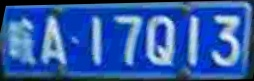

In [6]:
image

In [7]:
image = aug_transform(image)

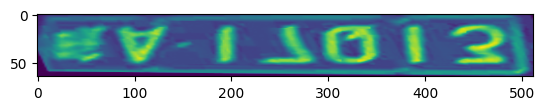

In [8]:
plt.imshow(image.squeeze(0))

In [9]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, root:str, fnames:str, transform=transform, symbols=symbols):
        self.root = root
        self.fnames = fnames
        self.transform = transform
        self.symbols = symbols
    def __len__(self):
        return len(self.fnames)
    
    def __getitem__(self, item):
        inputs = self.transform(Image.open(self.root+self.fnames[item]))                       #  Считываем изобаржение в тензор на вход модели
        labels = [self.symbols.index(s) for s in str(self.root+self.fnames[item])[-11:-4]]     #  Определяем символы в номере и переводим в список с индексами

        return inputs, torch.LongTensor(labels)

In [10]:
train_path = '/home/sempai/IdeaProjects/TransformersTrainig/CCPD2019-dl1/train/'
test_path = '/home/sempai/IdeaProjects/TransformersTrainig/CCPD2019-dl1/test/'
train_dataset = Dataset(train_path, os.listdir(train_path))
aug_train_dataset = Dataset(train_path, os.listdir(train_path), transform=aug_transform)
test_dataset = Dataset(test_path, os.listdir(test_path))

train_loader = torch.utils.data.DataLoader(train_dataset+aug_train_dataset, shuffle=True, num_workers=2, batch_size=64)
test_loader = torch.utils.data.DataLoader(test_dataset, shuffle=False, num_workers=2, batch_size=64)

# Model

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [13]:
class ConvEncoder(nn.Module):     #CNN
    def __init__(self):
        super(ConvEncoder, self).__init__()
        self.averagepooling = nn.AdaptiveAvgPool2d((8 , 8))           #  Пулинг выходного тензора
        hidden1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding=1, stride=2),
            nn.BatchNorm2d(num_features=32),
            nn.SELU()
        )
        hidden2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=1),                 #  Удваиваем каналы
            nn.BatchNorm2d(num_features=64),
            nn.SELU()                                   # Более современная функция активации
        )
        hidden3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.SELU()
        )
        self.features = nn.Sequential(      # Оптимальное количество блоков для быстрой и точной работы модели
            hidden1,
            hidden2,
            hidden3
            )
    def forward(self, x):
        x1 = self.features(x)
        x1 = self.averagepooling(x1)
        return x1

encoder = ConvEncoder()
encoder.eval()

ConvEncoder(
  (averagepooling): AdaptiveAvgPool2d(output_size=(8, 8))
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SELU()
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SELU()
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SELU()
    )
  )
)

In [18]:
class RNNClassifier(nn.Module):
    def __init__(self, device=device):
        super(RNNClassifier, self).__init__()
        self.linear = nn.Linear(64*128, 476)
        self.lstm = nn.LSTM(64, 32, bidirectional=True)  # 32-оптимальный вариант. При увеличении модель работает дольше, скор не поднимается
        self.selu = nn.SELU()
        self.device = device
        self.dropout = nn.Dropout1d(p=0.1)

    def forward(self, x):
        inputs = x.view(128, len(x), -1)            # Решейпим входной тензор для лстм
        hidden = (torch.zeros(2, len(x), 32).to(self.device), torch.zeros(2, len(x), 32).to(self.device))  # clean out hidden state
        out, _ = self.lstm(inputs, hidden)           # Получаем выход из лстм
        out = self.selu(out).reshape(len(x), -1)     # Решейпим под линейный слой и передаем активации
        out = self.dropout(out)
        y = self.linear(out)
        y_hat = y.reshape(len(y), 68, 7)      # batch_size * num_classes * positions
        return y_hat                      # Вместо 7 линейный классификаторов взял 1 на все позиции. Так работает быстрее, модель проще, а качество не страдает
cls = RNNClassifier()
cls.eval()

RNNClassifier(
  (linear): Linear(in_features=8192, out_features=476, bias=True)
  (lstm): LSTM(64, 32, bidirectional=True)
  (selu): SELU()
  (dropout): Dropout1d(p=0.1, inplace=False)
)

In [19]:
class Model(nn.Module):     # Модель целиком
    def __init__(self, encoder=encoder, decoder=cls):
        super(Model, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        encoded = self.encoder(x)
        logits = self.decoder(encoded)
        return logits
model = Model()
model.eval()

Model(
  (encoder): ConvEncoder(
    (averagepooling): AdaptiveAvgPool2d(output_size=(8, 8))
    (features): Sequential(
      (0): Sequential(
        (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SELU()
      )
      (1): Sequential(
        (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SELU()
      )
      (2): Sequential(
        (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SELU()
      )
    )
  )
  (decoder): RNNClassifier(
    (linear): Linear(in_features=8192, out_features=476, bias=True)
    (lstm): LSTM(64, 32, bidirectional=True)
    (selu): SELU()
    (dropout): Dropout1d(p=0.1, inplace

# Train & Evaluate

In [21]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.01)        #weight_decay, чтобы бороться с переобучением. Самый подходящий оптимизатор
criterion = torch.nn.CrossEntropyLoss()
cer = load("cer")                          # Метрика
print('Using device:', device)

Using device: cuda


In [22]:
def train(ep, model=model, criterion=criterion, 
          optimizer=optimizer,
          train_loader=train_loader, test_loader=test_loader,
          device=device, tqdm=tqdm,
          cer=cer, symbols=symbols):
    model = model.to(device)
    for i in range(ep):
        print(f'Iter {i+1} of {ep}')
        true_pred, total =0, 0
        loss_train, loss_test = 0, 0
        cer_pred, cer_true = [], []
        model = model.train()
        for batch in tqdm(train_loader):
            optimizer.zero_grad()
            inputs,y = batch[0].to(device), batch[1].to(device)
            y_hat = model(inputs)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            pred_labels = torch.argmax(y_hat, dim=1)            # Лэйблы полученных символов для каждого примера
            for batch_idx in range(pred_labels.shape[0]):       # Проходим по каждому примеру
                pred_, true_ = '', ''                           # Распознанный номер, Верный номер
                for example_idx in range(pred_labels.shape[1]):                     # Проходим по каждому лэйблу
                    pred_+= symbols[pred_labels[batch_idx, example_idx].item()]      # Добавляем символ в распознанный номер
                    true_+= symbols[y[batch_idx, example_idx].item()]                # Добавляем символ в верный номер
                if pred_ == true_: true_pred+=1                         # accuracy
                total+=1
                cer_pred.append(pred_)
                cer_true.append(true_)
            loss_train += loss.item()
        cer_train = cer.compute(predictions=cer_pred, references=cer_true)    #  Метрика для всей выборки
        loss_train /= len(train_loader)
        acc_train = true_pred / total

        with torch.no_grad():
            cer_pred, cer_true = [], []
            total, true_pred = 0, 0
            model = model.eval()
            for batch in test_loader:
                inputs, y = batch[0].to(device), batch[1].to(device)
                y_hat = model(inputs)
                loss = criterion(y_hat, y)
                pred_labels = torch.argmax(y_hat, dim=1)
                for batch_idx in range(pred_labels.shape[0]):
                    pred_, true_ = '', ''
                    for example_idx in range(pred_labels.shape[1]):
                        pred_ += symbols[pred_labels[batch_idx, example_idx].item()]
                        true_ += symbols[y[batch_idx, example_idx].item()]
                    if pred_ == true_: true_pred+=1
                    total += 1
                    cer_pred.append(pred_)
                    cer_true.append(true_)
                loss_test += loss.item()
            cer_test = cer.compute(predictions=cer_pred, references=cer_true)
            loss_test /= len(test_loader)
            acc_test = true_pred / total
        print(f'Train_accuracy: {acc_train}, Train_loss: {loss_train}, Train_cer: {cer_train}')
        print(f'Test_accuracy: {acc_test}, Test_loss: {loss_test}, Test_cer: {cer_test}')
        print()
    
    return model

In [23]:
model = train(20)

Iter 1 of 20


  0%|          | 0/6250 [00:00<?, ?it/s]

Train_accuracy: 0.8083133313331333, Train_loss: 0.36641676197424533, Train_cer: 0.08901140114011401
Test_accuracy: 0.9226922692269227, Test_loss: 0.057729274775998984, Test_cer: 0.015144371580015144

Iter 2 of 20


  0%|          | 0/6250 [00:00<?, ?it/s]

Train_accuracy: 0.8771677167716772, Train_loss: 0.2444334819244966, Train_cer: 0.07044275856157044
Test_accuracy: 0.9360936093609361, Test_loss: 0.04911114389053101, Test_cer: 0.012144071550012145

Iter 3 of 20


  0%|          | 0/6250 [00:00<?, ?it/s]

Train_accuracy: 0.8860636063606361, Train_loss: 0.23713361792059615, Train_cer: 0.06892296372494393
Test_accuracy: 0.9427942794279428, Test_loss: 0.045732269115496875, Test_cer: 0.01112968439701113

Iter 4 of 20


  0%|          | 0/6250 [00:00<?, ?it/s]

Train_accuracy: 0.8896064606460646, Train_loss: 0.2359866764790495, Train_cer: 0.06874115983026874
Test_accuracy: 0.9425942594259425, Test_loss: 0.044950145423548755, Test_cer: 0.011086822968011088

Iter 5 of 20


  0%|          | 0/6250 [00:00<?, ?it/s]

Train_accuracy: 0.8919366936693669, Train_loss: 0.2349198790167831, Train_cer: 0.0683000442901433
Test_accuracy: 0.9470947094709471, Test_loss: 0.044489236935605386, Test_cer: 0.010272455817010272

Iter 6 of 20


  0%|          | 0/6250 [00:00<?, ?it/s]

Train_accuracy: 0.8939068906890689, Train_loss: 0.23301883943835244, Train_cer: 0.06779177917791779
Test_accuracy: 0.9503950395039504, Test_loss: 0.044071388737132455, Test_cer: 0.009672395811009673

Iter 7 of 20


  0%|          | 0/6250 [00:00<?, ?it/s]

Train_accuracy: 0.8946094609460946, Train_loss: 0.23280226320817368, Train_cer: 0.06777749203491777
Test_accuracy: 0.9490949094909491, Test_loss: 0.04623940772863378, Test_cer: 0.009943851528009943

Iter 8 of 20


  0%|          | 0/6250 [00:00<?, ?it/s]

Train_accuracy: 0.8954095409540954, Train_loss: 0.23193296387425508, Train_cer: 0.06732530395896733
Test_accuracy: 0.9476947694769476, Test_loss: 0.04701469879809494, Test_cer: 0.010086722958010087

Iter 9 of 20


  0%|          | 0/6250 [00:00<?, ?it/s]

Train_accuracy: 0.8962246224622462, Train_loss: 0.23102039064273935, Train_cer: 0.06722386524366722
Test_accuracy: 0.946994699469947, Test_loss: 0.04573523943537882, Test_cer: 0.009943851528009943

Iter 10 of 20


  0%|          | 0/6250 [00:00<?, ?it/s]

Train_accuracy: 0.8955895589558955, Train_loss: 0.23297494070052052, Train_cer: 0.0678078522137928
Test_accuracy: 0.952995299529953, Test_loss: 0.04180668145842675, Test_cer: 0.009129484377009129

Iter 11 of 20


  0%|          | 0/6250 [00:00<?, ?it/s]

Train_accuracy: 0.8969046904690469, Train_loss: 0.23083613911611958, Train_cer: 0.06713314188561713
Test_accuracy: 0.9496949694969496, Test_loss: 0.045804174105298655, Test_cer: 0.009958138671009958

Iter 12 of 20


  0%|          | 0/6250 [00:00<?, ?it/s]

Train_accuracy: 0.897022202220222, Train_loss: 0.23075097554413573, Train_cer: 0.06713849956424214
Test_accuracy: 0.9530953095309531, Test_loss: 0.041824712358329116, Test_cer: 0.009315217236009315

Iter 13 of 20


  0%|          | 0/6250 [00:00<?, ?it/s]

Train_accuracy: 0.8966846684668467, Train_loss: 0.23202961322004442, Train_cer: 0.06753675367536753
Test_accuracy: 0.9533953395339534, Test_loss: 0.041442694557514814, Test_cer: 0.009000900090009001

Iter 14 of 20


  0%|          | 0/6250 [00:00<?, ?it/s]

Train_accuracy: 0.8965896589658966, Train_loss: 0.23253459466202533, Train_cer: 0.06760211735459261
Test_accuracy: 0.9506950695069507, Test_loss: 0.04664864452966566, Test_cer: 0.00962953438200963

Iter 15 of 20


  0%|          | 0/6250 [00:00<?, ?it/s]

Train_accuracy: 0.8968021802180218, Train_loss: 0.2321662638230226, Train_cer: 0.06748139099624248
Test_accuracy: 0.9478947894789479, Test_loss: 0.04654906415617817, Test_cer: 0.010258168674010259

Iter 16 of 20


  0%|          | 0/6250 [00:00<?, ?it/s]

Train_accuracy: 0.8970722072207221, Train_loss: 0.2316819493199585, Train_cer: 0.06731887474461731
Test_accuracy: 0.9543954395439544, Test_loss: 0.04498613027013782, Test_cer: 0.008786592945008786

Iter 17 of 20


  0%|          | 0/6250 [00:00<?, ?it/s]

Train_accuracy: 0.8977947794779478, Train_loss: 0.23061645016723442, Train_cer: 0.06712314088551713
Test_accuracy: 0.9560956095609561, Test_loss: 0.04170979051012842, Test_cer: 0.008786592945008786

Iter 18 of 20


  0%|          | 0/6250 [00:00<?, ?it/s]

Train_accuracy: 0.8977947794779478, Train_loss: 0.23082960619168022, Train_cer: 0.06695776720529195
Test_accuracy: 0.9527952795279528, Test_loss: 0.044117165118037684, Test_cer: 0.009186632949009187

Iter 19 of 20


  0%|          | 0/6250 [00:00<?, ?it/s]

Train_accuracy: 0.8983398339833983, Train_loss: 0.22931561503193748, Train_cer: 0.06666738102381667
Test_accuracy: 0.9541954195419542, Test_loss: 0.046196662034238035, Test_cer: 0.009129484377009129

Iter 20 of 20


  0%|          | 0/6250 [00:00<?, ?it/s]

Train_accuracy: 0.8984748474847485, Train_loss: 0.22931642273736477, Train_cer: 0.06672167216721672
Test_accuracy: 0.9520952095209521, Test_loss: 0.0423442026367411, Test_cer: 0.009172345806009173



In [25]:
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, nesterov=True)        # финальное обучение (используем сгд, т.к. слабо переобучается. Иннерция + Нестеров для преодоления локальных минимумов)

In [26]:
model = train(5, model=model, optimizer=optimizer)

Iter 1 of 5


  0%|          | 0/6250 [00:00<?, ?it/s]

Train_accuracy: 0.8985298529852985, Train_loss: 0.23113839940487857, Train_cer: 0.06716064463589216
Test_accuracy: 0.9586958695869587, Test_loss: 0.0383969858892345, Test_cer: 0.008015087223008015

Iter 2 of 5


  0%|          | 0/6250 [00:00<?, ?it/s]

Train_accuracy: 0.8981398139813982, Train_loss: 0.232517958740467, Train_cer: 0.06772998728444272
Test_accuracy: 0.9593959395939594, Test_loss: 0.03795975568010264, Test_cer: 0.0079007900790079

Iter 3 of 5


  0%|          | 0/6250 [00:00<?, ?it/s]

Train_accuracy: 0.8991574157415742, Train_loss: 0.23052058309899526, Train_cer: 0.06708349406369209
Test_accuracy: 0.9594959495949595, Test_loss: 0.03779626631283255, Test_cer: 0.007843641507007844

Iter 4 of 5


  0%|          | 0/6250 [00:00<?, ?it/s]

Train_accuracy: 0.8986648664866487, Train_loss: 0.23162137563322216, Train_cer: 0.06704991927764205
Test_accuracy: 0.9597959795979598, Test_loss: 0.03749109356023466, Test_cer: 0.007800780078007801

Iter 5 of 5


  0%|          | 0/6250 [00:00<?, ?it/s]

Train_accuracy: 0.8992124212421242, Train_loss: 0.23040101473249203, Train_cer: 0.0671120683496921
Test_accuracy: 0.9597959795979598, Test_loss: 0.03752652039213082, Test_cer: 0.007843641507007844



# Анализ ошибок

In [27]:
# Читаем изобаржение для визуализации
def read(name, path=test_path, transform=transform):
    name = [n for n in os.listdir(path) if name in n][0]
    fp = path+name
    image = transform(Image.open(fp))
    return image.squeeze(0)

In [28]:
# Предиктим тестовую выборку
with torch.no_grad():
    model = model.eval()
    cer_dict = dict()             # Словарь вида { (верное/предсказанное) : метрика примера }
    for batch in test_loader:
        inputs,y = batch[0].to(device), batch[1].to(device)
        y_hat = model(inputs)
        pred_labels = torch.argmax(y_hat, dim=1)
        for batch_idx in range(pred_labels.shape[0]):
            pred_, true_ = '', ''
            for example_idx in range(pred_labels.shape[1]):
                pred_+=symbols[pred_labels[batch_idx, example_idx].item()]
                true_+=symbols[y[batch_idx, example_idx].item()]
            cer_score = cer.compute(predictions=[pred_], references=[true_])       # Считаем метрику для каждого примера отдельно
            cer_dict[(true_,pred_)] = cer_score

In [29]:
# Сортируем список по возрастанию метрик
sorted_tuples = sorted(cer_dict.items(), key=operator.itemgetter(1))
sorted_dict = OrderedDict()
for k, v in sorted_tuples:
    sorted_dict[k] = v
print(sorted_dict)

OrderedDict([(('皖AA7P01', '皖AA7P01'), 0.0), (('皖APB166', '皖APB166'), 0.0), (('皖AFC875', '皖AFC875'), 0.0), (('皖AJ652Y', '皖AJ652Y'), 0.0), (('皖AS616L', '皖AS616L'), 0.0), (('皖AJ1R17', '皖AJ1R17'), 0.0), (('皖A0Q665', '皖A0Q665'), 0.0), (('苏A6XR88', '苏A6XR88'), 0.0), (('皖AXT290', '皖AXT290'), 0.0), (('皖ABJ623', '皖ABJ623'), 0.0), (('皖AH689F', '皖AH689F'), 0.0), (('皖AH0U31', '皖AH0U31'), 0.0), (('皖AP0W27', '皖AP0W27'), 0.0), (('皖A539T6', '皖A539T6'), 0.0), (('皖A513A0', '皖A513A0'), 0.0), (('皖A0C310', '皖A0C310'), 0.0), (('皖AS948Z', '皖AS948Z'), 0.0), (('皖A26J71', '皖A26J71'), 0.0), (('皖A23N86', '皖A23N86'), 0.0), (('皖A96Z09', '皖A96Z09'), 0.0), (('皖AH5Z37', '皖AH5Z37'), 0.0), (('皖AA4767', '皖AA4767'), 0.0), (('皖A64131', '皖A64131'), 0.0), (('皖AEJ078', '皖AEJ078'), 0.0), (('皖AJ5354', '皖AJ5354'), 0.0), (('皖APG285', '皖APG285'), 0.0), (('皖AM211P', '皖AM211P'), 0.0), (('皖A32349', '皖A32349'), 0.0), (('皖AE2637', '皖AE2637'), 0.0), (('皖AT760D', '皖AT760D'), 0.0), (('皖ABG705', '皖ABG705'), 0.0), (('皖AY8349', '皖AY8349'), 0

/home/sempai/IdeaProjects/TransformersTrainig/venv/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Glyph 30358 (\N{CJK UNIFIED IDEOGRAPH-7696}) missing from current font.
  func(*args, **kwargs)
/home/sempai/IdeaProjects/TransformersTrainig/venv/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Glyph 33487 (\N{CJK UNIFIED IDEOGRAPH-82CF}) missing from current font.
  func(*args, **kwargs)
/home/sempai/IdeaProjects/TransformersTrainig/venv/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Glyph 27818 (\N{CJK UNIFIED IDEOGRAPH-6CAA}) missing from current font.
  func(*args, **kwargs)
/home/sempai/IdeaProjects/TransformersTrainig/venv/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Glyph 40065 (\N{CJK UNIFIED IDEOGRAPH-9C81}) missing from current font.
  func(*args, **kwargs)
/home/sempai/IdeaProjects/TransformersTrainig/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 30358

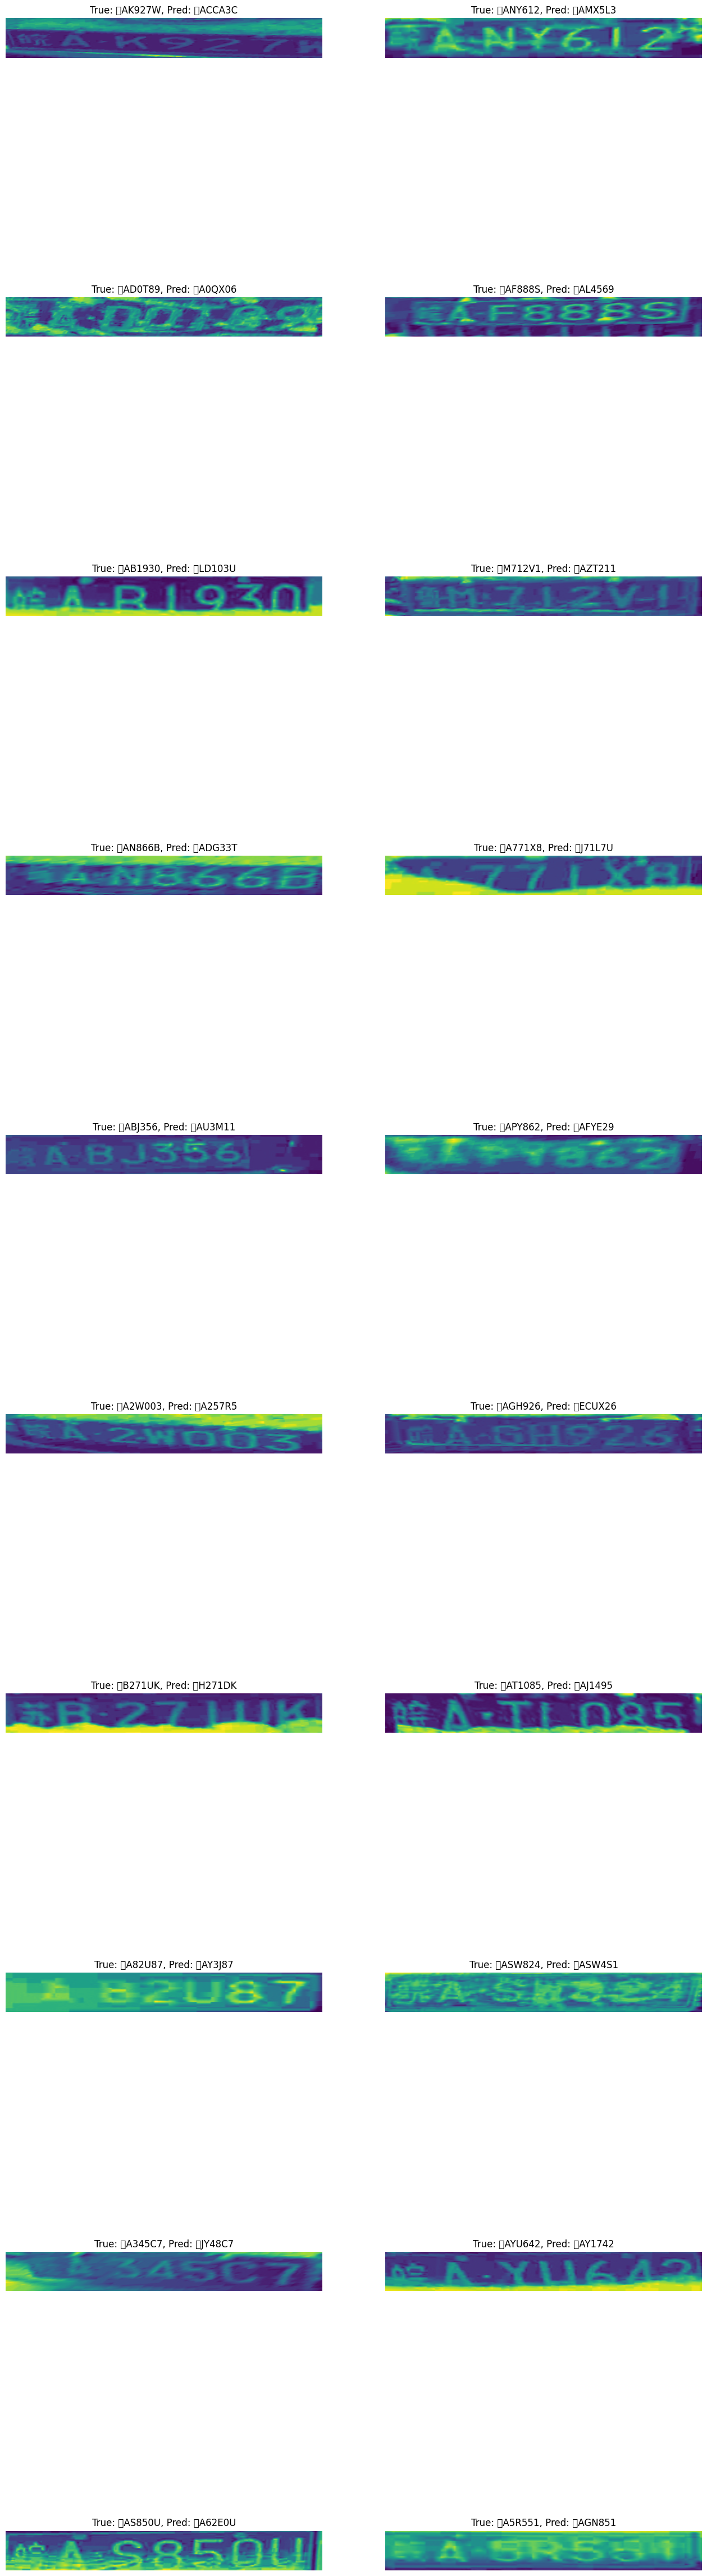

In [30]:
# визуализируем топ 20 неудачных для модели примеров
fig = plt.figure(figsize=(16, 128))
keys_ = list(sorted_dict.keys())
for i in range(1,21):
    k = keys_[-i]
    name = k[0]
    image = read(name)

    fig.add_subplot(20, 2, i)
    plt.imshow(image)
    plt.axis('off')
    plt.title(f'True: {k[0]}, Pred: {k[1]}')


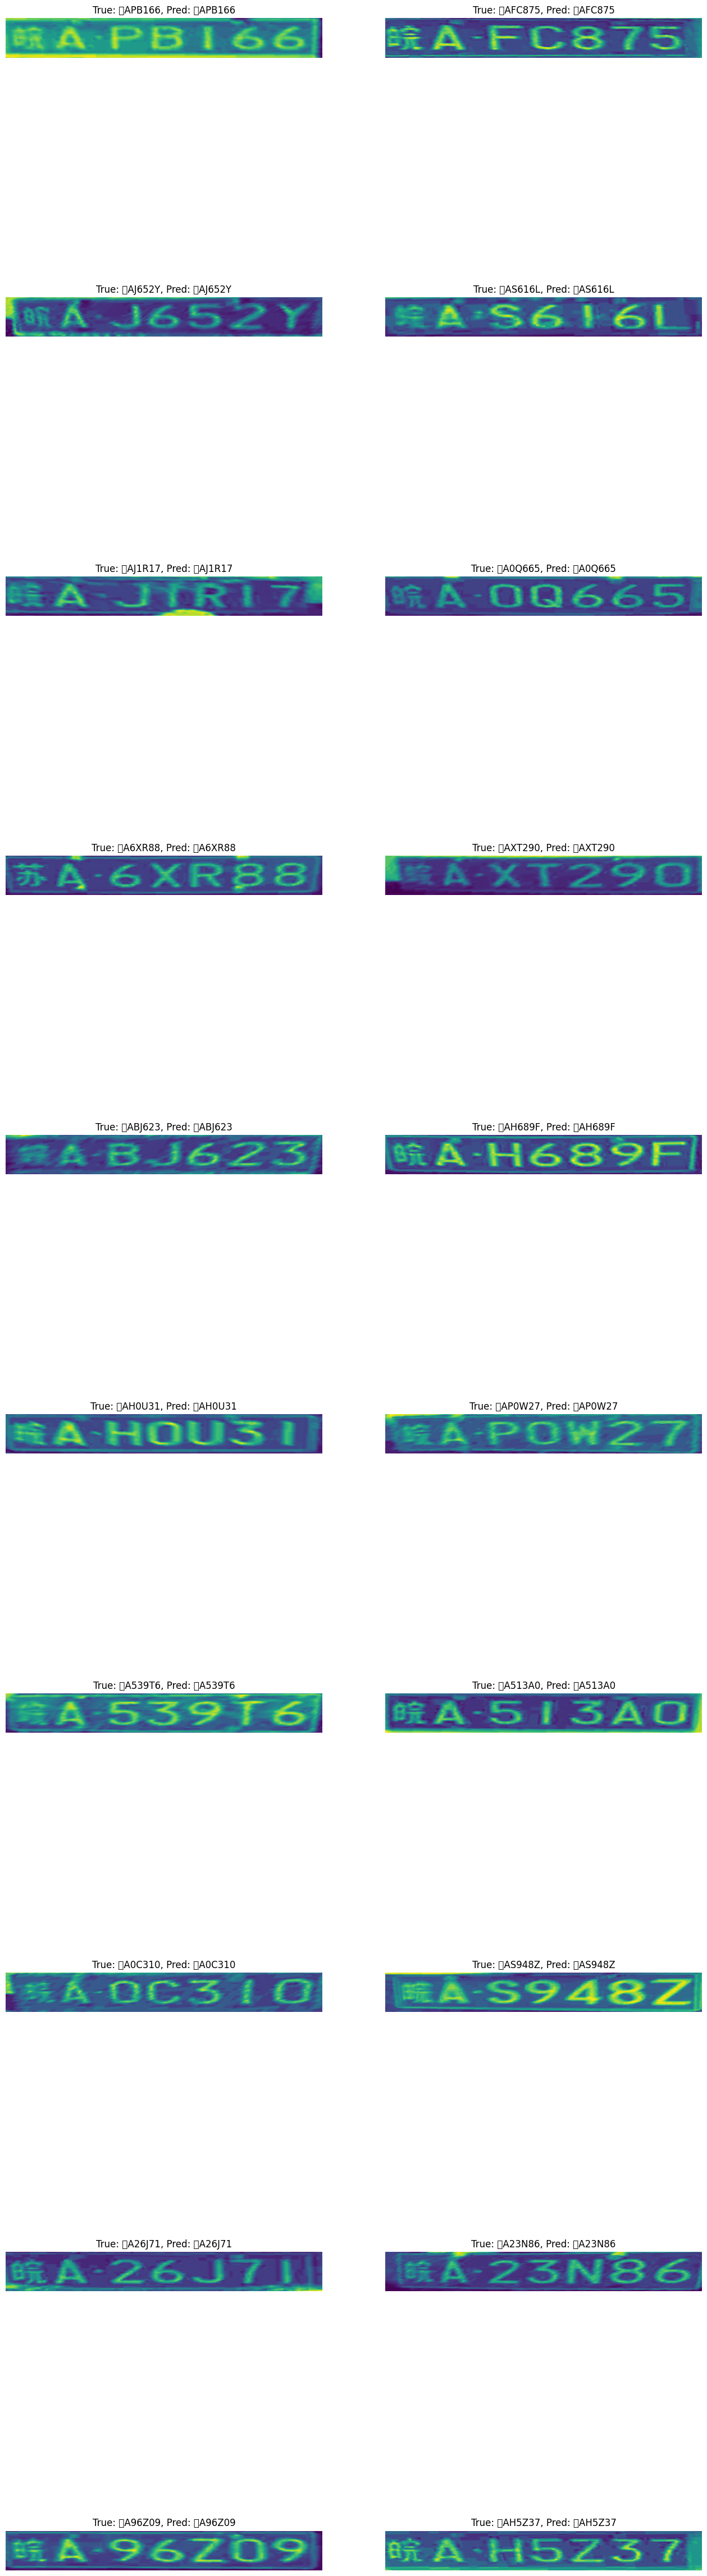

In [31]:
# Для сравнения визуализируем удачные номера
fig = plt.figure(figsize=(16, 128))
keys_ = list(sorted_dict.keys())
for i in range(1,21):
    k = keys_[i]
    name = k[0]
    image = read(name)

    fig.add_subplot(20, 2, i)
    plt.imshow(image)
    plt.axis('off')
    plt.title(f'True: {k[0]}, Pred: {k[1]}')


## Вывод. На выборках заметно, что модель ошибается на номерах с плохим качеством изображения. Практически невозможно распознавать размытые иероглифы, т.к. их форма намного сложнее, чем у букв и цифр. При плохом качестве модель вегда выбирает самый распространенный иероглиф. Скорее всего, нужно почитстить датасет от некачественных примеров (их мало, но они могут портить скор модели), а также обучить модель на отдельной выборке различать именно иероглифы. Возможно, нужна модель, которая будет улучшать качество входного изображения. Также можно увеличить кол-во параметров модели, что увеличит скор, но замедлит инференс.
